In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import bbi
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import bioframe as bf
import cooltools
import cooltools.lib.plotting
import cooler
from tqdm import tqdm
from itertools import product
from scipy.ndimage import gaussian_filter
import PeaksManipulation

In [29]:
#### A way to use externel fonts in matplotlib without installing it
from matplotlib import font_manager
font_dirs = ['/users/ankit.gupta/.fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
#### A way to use externel fonts in matplotlib without installing it

mpl.rcParams['font.family'] = 'Nunito'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2

In [6]:
tssOvlp = pd.read_csv("../atac_h3k27ac_peaks_overlap/promoter_peaks_using_h3k27ac.tsv",sep="\t")
intergenic = pd.read_csv("../atac_h3k27ac_peaks_overlap/enhancer_peaks_using_h3k27ac.tsv",sep="\t")

In [7]:
intergenic["type"] = ["enh"] * len(intergenic)
tssOvlp["type"] = ["tss"] * len(tssOvlp)

In [8]:
intergenic

,chrom,start,end,length,chrom_,start_,end_,gene_name_,strand_,gene_len_,distance,type
0,chr1,7066405,7069093,2688,chr1,7079001,7163707,Pcmtd1,+,84706,9908,enh
1,chr1,9628528,9630162,1634,chr1,9550913,9621256,2610203C22Rik,-,70343,7272,enh
2,chr1,12992303,12993303,1000,chr1,12856630,12981258,Slco5a1,-,124628,11045,enh
3,chr1,13041947,13043066,1119,chr1,13103538,13117244,Prdm14,-,13706,60472,enh
4,chr1,13372758,13374812,2054,chr1,13129186,13364164,Ncoa2,-,234978,8594,enh
...,...,...,...,...,...,...,...,...,...,...,...,...
5581,chrX,104521528,104522808,1280,chrX,104539925,104540951,Gm14833,+,1026,17117,enh
5582,chrX,127278779,127279808,1029,chrX,127422205,127422314,AL671906.1,-,109,142397,enh
5583,chrX,147391191,147392191,1000,chrX,147417684,147451865,Gnl3l,-,34181,25493,enh
5584,chrX,160317270,160318401,1131,chrX,160346949,160371598,Ap1s2,+,24649,28548,enh


In [9]:
genes = pd.read_csv("../../results/files/mm9.genes.info.csv")
# genes = genes.drop_duplicates(subset=["gene_name"])
genes["gene_len"] = abs(genes.end - genes.start)
genes = genes.rename(columns={"gene_name":"gene_name_"})

In [10]:
expressedGenes = tssOvlp.copy()#.query("biotype_ == 'protein_coding'",engine="python")
expressedGenes = pd.merge(expressedGenes, genes ,on=["chrom","gene_name_"], how="left",suffixes=["","_g"])
expressedGenes = expressedGenes.drop_duplicates(subset=["chrom","gene_name_"]).reset_index(drop=True)
expressedGenes = PeaksManipulation.GetIntervalsFromPeaks(expressedGenes,500)
expressedGenes = expressedGenes.drop(["start_g","end_g","strand","gene_len"],axis=1)

In [11]:
expressedGenes

,chrom,start,end,length,chrom_,start_,end_,gene_name_,strand_,gene_len_,distance,type
0,chr1,4774979,4775979,2287,chr1,4775770,4775870,Mrpl15,-,12533,0,tss
1,chr1,7078386,7079386,1825,chr1,7078951,7079051,Pcmtd1,+,84706,0,tss
2,chr1,7387476,7388476,2396,chr1,7387832,7387932,Gm16899,-,48395,0,tss
3,chr1,9534940,9535940,1727,chr1,9535439,9535539,Rrs1,+,2046,0,tss
4,chr1,9689814,9690814,2320,chr1,9690240,9690340,Mybl1,-,32794,0,tss
...,...,...,...,...,...,...,...,...,...,...,...,...
9577,chrX,155810063,155811063,1415,chrX,155810060,155810160,Eif1ax,+,17750,0,tss
9578,chrX,156065284,156066284,2307,chrX,156065154,156065254,Sh3kbp1,+,350797,0,tss
9579,chrX,160396161,160397161,1610,chrX,160396543,160396643,Zrsr2,-,23218,0,tss
9580,chrX,160857465,160858465,1064,chrX,160857675,160857775,Piga,+,14123,0,tss


In [13]:
peaksWithTSS = expressedGenes
peaksWithTSS

,chrom,start,end,length,chrom_,start_,end_,gene_name_,strand_,gene_len_,distance,type
0,chr1,4774979,4775979,2287,chr1,4775770,4775870,Mrpl15,-,12533,0,tss
1,chr1,7078386,7079386,1825,chr1,7078951,7079051,Pcmtd1,+,84706,0,tss
2,chr1,7387476,7388476,2396,chr1,7387832,7387932,Gm16899,-,48395,0,tss
3,chr1,9534940,9535940,1727,chr1,9535439,9535539,Rrs1,+,2046,0,tss
4,chr1,9689814,9690814,2320,chr1,9690240,9690340,Mybl1,-,32794,0,tss
...,...,...,...,...,...,...,...,...,...,...,...,...
9577,chrX,155810063,155811063,1415,chrX,155810060,155810160,Eif1ax,+,17750,0,tss
9578,chrX,156065284,156066284,2307,chrX,156065154,156065254,Sh3kbp1,+,350797,0,tss
9579,chrX,160396161,160397161,1610,chrX,160396543,160396643,Zrsr2,-,23218,0,tss
9580,chrX,160857465,160858465,1064,chrX,160857675,160857775,Piga,+,14123,0,tss


In [16]:
pairsParamsDict = {"suffixes":["1","2"]}#, "max_intervening":10} ## 8 is fixed for now, dont change it
pairSites = {
             "30-300kb" : bf.pair_by_distance(peaksWithTSS,30_000,300_000,**pairsParamsDict).drop_duplicates().reset_index(drop=True), 
            }

In [17]:
for i in pairSites.keys():
    df = pairSites[i]
    pairSites[i]["distance"] = df["start2"] - df["start1"]
    print(i, len(df))

30-300kb 27791


In [18]:
pairSites["30-300kb"]

,chrom1,start1,end1,length1,chrom_1,start_1,end_1,gene_name_1,strand_1,gene_len_1,...,length2,chrom_2,start_2,end_2,gene_name_2,strand_2,gene_len_2,distance2,type2,distance
0,chr18,3336966,3337966,2030,chr18,3337696,3337796,Crem,-,71700,...,1797,chr18,3507905,3508005,Bambi,+,8447,0,tss,170296
1,chr18,4353091,4354091,1892,chr18,4352963,4353063,Map3k8,-,21688,...,1302,chr18,4634877,4634977,9430020K01Rik,+,47939,0,tss,281613
2,chr18,4376485,4377485,3453,chr18,4375540,4375640,Mtpap,+,21738,...,1302,chr18,4634877,4634977,9430020K01Rik,+,47939,0,tss,258219
3,chr18,5334152,5335152,1100,chr18,5334387,5334487,Zfp438,-,124408,...,2089,chr18,5592385,5592485,RP23-278M16.2,-,100936,0,tss,257382
4,chr18,5334152,5335152,1100,chr18,5334387,5334487,Zfp438,-,124408,...,2851,chr18,5603692,5603792,RP23-345J21.1,+,39129,0,tss,269419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27786,chrX,160396161,160397161,1610,chrX,160396543,160396643,Zrsr2,-,23218,...,2152,chrX,160514375,160514475,Siah1b,-,5788,0,tss,117089
27787,chrX,162878087,162879087,1531,chrX,162878586,162878686,Ofd1,-,50671,...,1997,chrX,162917749,162917849,Rab9,-,22614,0,tss,38883
27788,chrX,163539837,163540837,2881,chrX,163539972,163540072,Gm15232,-,13997,...,4740,chrX,163647197,163647297,Tmsb4x,-,2222,0,tss,108116
27789,chrX,163647953,163648953,4740,chrX,163647197,163647297,Tmsb4x,-,2222,...,2064,chrX,163768440,163768540,Tlr7,-,25629,0,tss,119943


## Micro-C files

In [20]:
microCRes = 5000
cools = {}
cools["WT"] = cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library_group/WT.mm9.mapq_30.100.mcool::resolutions/{microCRes}")
cools["KO"] = cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library_group/KO.mm9.mapq_30.100.mcool::resolutions/{microCRes}")
mm9_chromsizes = bf.fetch_chromsizes('mm9')
mm9_cens = bf.fetch_centromeres('mm9') ### Mouse chromosomes are telocentric
mm9_chroms = bf.core.construction.add_ucsc_name_column(bf.make_chromarms(mm9_chromsizes,  mm9_cens))
mm9_chroms = mm9_chroms[mm9_chroms.chrom.isin(cools["WT"].chromnames)].reset_index(drop=True)

In [21]:
%%time

# expectedWT = cooltools.expected_cis(cools["WT"], view_df=mm9_chroms, nproc=20, chunksize=1_000_000)
# expectedKO = cooltools.expected_cis(cools["KO"], view_df=mm9_chroms, nproc=20, chunksize=1_000_000)
# expectedWT.to_csv("expected_cis_WT_group_5kb_res.tsv",sep="\t",index=None)
# expectedKO.to_csv("expected_cis_KO_group_5kb_res.tsv",sep="\t",index=None)

expectedWT = pd.read_csv("../microC_pileups/expected_cis_WT_group_5kb_res.tsv",sep="\t")
expectedKO = pd.read_csv("../microC_pileups/expected_cis_KO_group_5kb_res.tsv",sep="\t")

### Only to get bigger window and obs/expected for the pileup
loopsFlankbig = 200_000
pairsPileup = {}
for i in tqdm(pairSites.keys()):
    df = pairSites[i]
    pairsPileup[i] = {}
    pairsPileup[i] = dict(WT=cooltools.pileup(cools["WT"], df, view_df=mm9_chroms,expected_df=expectedWT, flank=loopsFlankbig, nproc=10), 
                          KO=cooltools.pileup(cools["KO"], df, view_df=mm9_chroms,expected_df=expectedKO, flank=loopsFlankbig, nproc=10))

100%|██████████| 1/1 [01:23<00:00, 83.66s/it]

CPU times: user 10.7 s, sys: 5.49 s, total: 16.2 s
Wall time: 1min 24s


In [22]:
for i in pairSites.keys():
    df = pairSites[i]
    print(i, len(df))
    print(i, pairsPileup[i]["WT"].shape)

30-300kb 27791
30-300kb (81, 81, 27791)


In [42]:
df

,chrom1,start1,end1,peak_type1,transcript_name_1,strand1,distance1,chrom2,start2,end2,peak_type2,transcript_name_2,strand2,distance2
0,chr16,11175655,11175916,tss,Zc3h7a,-,0,chr16,11909238,11909301,tss,Cpped1,-,0
1,chr16,11176397,11176602,tss,Zc3h7a,-,0,chr16,11909238,11909301,tss,Cpped1,-,0
2,chr16,11176397,11176602,tss,Zc3h7a,-,0,chr16,11909511,11909598,tss,Cpped1,-,0
3,chr16,11176682,11176883,tss,Zc3h7a,-,196,chr16,11909238,11909301,tss,Cpped1,-,0
4,chr16,11176682,11176883,tss,Zc3h7a,-,196,chr16,11909511,11909598,tss,Cpped1,-,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61880,chr11,121120649,121120675,tss,Foxk2,+,0,chr11,121564619,121564722,tss,Metrnl,+,0
61881,chr11,121121137,121121336,tss,Foxk2,+,0,chr11,121564619,121564722,tss,Metrnl,+,0
61882,chr11,121121623,121121684,tss,Foxk2,+,0,chr11,121564619,121564722,tss,Metrnl,+,0
61883,chr11,121121708,121121725,tss,Foxk2,+,0,chr11,121564619,121564722,tss,Metrnl,+,0


In [23]:
cond01 = "(type1 == 'tss' & type2 == 'tss')"
cond03 = "(strand_1 == '+' & strand_2 == '+')"
cond04 = "(strand_1 == '-' & strand_2 == '-')"
cond05 = "(strand_1 == '+' & strand_2 == '-')"
cond06 = "(strand_1 == '-' & strand_2 == '+')"

condStr = ["tss --> <-- tss", "<-- tss tss -->", "tss --> tss -->"]

cond1 = f"{cond01} & {cond05}" ## always convergent
cond2 = f"{cond01} & {cond06}" ## always divergent
cond3 = f"{cond01} & ({cond03} | {cond04})" ## always from ctcf to tss in the direction of transcription

maskCond1 = lambda x: np.array(x["strand_1"] == '-', dtype=bool)

(type1 == 'tss' & type2 == 'tss') & ((strand_1 == '+' & strand_2 == '+') | (strand_1 == '-' & strand_2 == '-')) 27791


<timed exec>:26: RuntimeWarning: Mean of empty slice
<timed exec>:33: RuntimeWarning: Mean of empty slice
<timed exec>:41: RuntimeWarning: Mean of empty slice


CPU times: user 6.22 s, sys: 2.43 s, total: 8.66 s
Wall time: 7.38 s


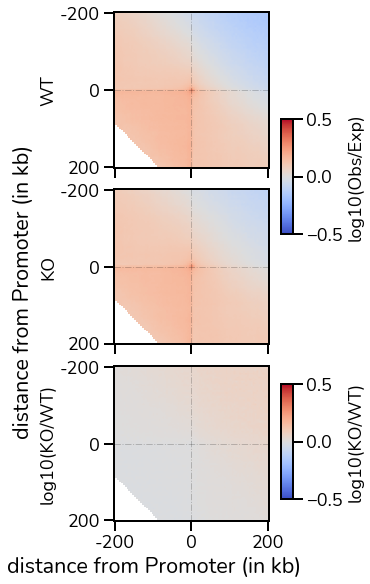

In [35]:
%%time

pileupKwargsDictOE = dict(cmap="coolwarm",vmin=-0.50,vmax=0.50,aspect="auto")
pileupKwargsDictRatio = dict(cmap="coolwarm",vmin=-0.5,vmax=0.5,aspect="auto")

fig,ax = plt.subplots(3,1,figsize=(4,8),sharex=True,sharey=True,constrained_layout=True)
distRange = "30-300kb"

centerAt = loopsFlankbig // microCRes
ax[0].set_xticks([0,centerAt,centerAt*2],[-loopsFlankbig//1000,0,loopsFlankbig//1000])
ax[0].set_yticks([0,centerAt,centerAt*2],[-loopsFlankbig//1000,0,loopsFlankbig//1000])
ax[0].set_ylabel("WT")
ax[1].set_ylabel("KO")
ax[2].set_ylabel("log10(KO/WT)")
# for ic,i in enumerate([cond1,cond2,cond3]):
    
# ax[0].set_title(condStr[ic])
pileupKwargsDict = pileupKwargsDictOE
df = pairSites[distRange]#.query(i,engine="python")
print(i, len(df))    
mask = maskCond1(df)

covWT = pairsPileup[distRange]["WT"]#[:,:,list(df.index)].copy()    
covKO = pairsPileup[distRange]["KO"]#[:,:,list(df.index)].copy()
# if i == cond3:
#     covWT[:, :, mask] = np.transpose(covWT[:, :, mask],axes=(1,0,2))[::-1, ::-1, ]#covWT[::-1, ::-1, mask]
#     covKO[:, :, mask] = np.transpose(covKO[:, :, mask],axes=(1,0,2))[::-1, ::-1, ]#covKO[::-1, ::-1, mask]
ax[0].imshow(np.log10(np.nanmean(covWT,axis=2)),**pileupKwargsDict)
ax[0].axvline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
ax[0].axhline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
ax[0].set_aspect(1)
# ax[0].spines.bottom.set_visible(False)
# ax[0].spines.left.set_visible(False)

ax[1].imshow(np.log10(np.nanmean(covKO,axis=2)),**pileupKwargsDict)
ax[1].axvline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
ax[1].axhline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
ax[1].set_aspect(1)
# ax[1].spines.bottom.set_visible(False)
# ax[1].spines.left.set_visible(False)    

pileupKwargsDict = pileupKwargsDictRatio
ratio = np.log10(np.nanmean(covKO,axis=2)/np.nanmean(covWT,axis=2))
ax[2].imshow(ratio,**pileupKwargsDict)
ax[2].axvline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
ax[2].axhline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
ax[2].set_aspect(1)
# ax[2].spines.bottom.set_visible(False)
# ax[2].spines.left.set_visible(False)

ax2 = fig.add_axes([0.94, 0.6,0.04, 0.2])
cb2 = mpl.colorbar.ColorbarBase(ax2, orientation='vertical', 
                               cmap='coolwarm',norm=mpl.colors.Normalize(-0.50, 0.50),label="log10(Obs/Exp)")

ax3 = fig.add_axes([0.94, 0.14,0.04, 0.2])
cb3 = mpl.colorbar.ColorbarBase(ax3, orientation='vertical', 
                               cmap='coolwarm',norm=mpl.colors.Normalize(-0.50, 0.50),label="log10(KO/WT)")

# fig.suptitle(distRange)
fig.supxlabel("distance from Promoter (in kb)")
fig.supylabel("distance from Promoter (in kb)")

# plt.savefig("microC_pileup_at_p-p_loops.png",dpi=300,bbox_inches="tight")
# plt.savefig("microC_pileup_at_p-p_loops.pdf",dpi=300,bbox_inches="tight")

# 3. For TSS vs. Non-TSS sites

In [36]:
pairsParamsDict = {"suffixes":["1","2"]}#, "max_intervening":10} ## 8 is fixed for now, dont change it
pairSites2 = {
              "30-300kb" : bf.pair_by_distance(pd.concat((peaksWithTSS,intergenic)),30_000,300_000,**pairsParamsDict).drop_duplicates().reset_index(drop=True), 
            }

In [37]:
pairSites2["30-300kb"] = pairSites2["30-300kb"].query("type1 == 'tss' & type2 == 'enh' | type1 == 'enh' & type2 == 'tss'").reset_index(drop=True)
pairSites2["30-300kb"]

,chrom1,start1,end1,length1,chrom_1,start_1,end_1,gene_name_1,strand_1,gene_len_1,...,end2,length2,chrom_2,start_2,end_2,gene_name_2,strand_2,gene_len_2,distance2,type2
0,chr18,5124911,5125911,1000,chr18,4920538,5119297,Svil,+,198759,...,5335152,1100,chr18,5334387,5334487,Zfp438,-,124408,0,tss
1,chr18,5348094,5350029,1935,chr18,5210029,5334437,Zfp438,-,124408,...,5592534,2089,chr18,5592385,5592485,RP23-278M16.2,-,100936,0,tss
2,chr18,5348094,5350029,1935,chr18,5210029,5334437,Zfp438,-,124408,...,5604571,2851,chr18,5603692,5603792,RP23-345J21.1,+,39129,0,tss
3,chr18,5591534,5592534,2089,chr18,5592385,5592485,RP23-278M16.2,-,100936,...,5807627,1937,chr18,5591870,5775741,Zeb1,+,183871,29949,enh
4,chr18,5591534,5592534,2089,chr18,5592385,5592485,RP23-278M16.2,-,100936,...,5810358,2119,chr18,5591870,5775741,Zeb1,+,183871,32498,enh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18991,chrX,163664416,163665732,1316,chrX,163680626,163702261,Tlr8,-,21635,...,163820833,1111,chrX,163820631,163820731,Prps2,-,36427,0,tss
18992,chrX,163666042,163669764,3722,chrX,163680626,163702261,Tlr8,-,21635,...,163820833,1111,chrX,163820631,163820731,Prps2,-,36427,0,tss
18993,chrX,163670339,163671609,1270,chrX,163680626,163702261,Tlr8,-,21635,...,163820833,1111,chrX,163820631,163820731,Prps2,-,36427,0,tss
18994,chrX,163776949,163779252,2303,chrX,163784254,163820681,Prps2,-,36427,...,163820833,1111,chrX,163820631,163820731,Prps2,-,36427,0,tss


In [38]:
loopsFlankbig2 = 200_000
pairsPileup2 = {}
for i in tqdm(pairSites2.keys()):
    df = pairSites2[i]
    pairsPileup2[i] = {}
    pairsPileup2[i] = dict(WT=cooltools.pileup(cools["WT"], df, view_df=mm9_chroms,expected_df=expectedWT, flank=loopsFlankbig2, nproc=10), 
                          KO=cooltools.pileup(cools["KO"], df, view_df=mm9_chroms,expected_df=expectedKO, flank=loopsFlankbig2, nproc=10))

100%|██████████| 1/1 [01:13<00:00, 73.14s/it]


In [39]:
cond01 = "(type1 == 'tss' & type2 == 'enh')"
cond02 = "(type1 == 'enh' & type2 == 'tss')"
cond05 = "(strand_1 == '+' & strand_2 == '-')"
cond06 = "(strand_1 == '-' & strand_2 == '+')"

condStr = ["tss --> enh", "<-- tss enh"]

cond3 = f"({cond01} & {cond05}) | ({cond02} & {cond05})"
cond4 = f"({cond02} & {cond06}) | ({cond01} & {cond06})"

maskCond1 = lambda x: np.array(x["type1"] == 'enh', dtype=bool)
maskCond2 = lambda x: np.array(x["type1"] == 'enh', dtype=bool)
maskCond3 = lambda x: np.array(x["type1"] == 'enh', dtype=bool)
maskCond4 = lambda x: np.array(x["type1"] == 'enh', dtype=bool)

30-300kb 18996


<timed exec>:22: RuntimeWarning: Mean of empty slice
<timed exec>:31: RuntimeWarning: Mean of empty slice
<timed exec>:39: RuntimeWarning: Mean of empty slice


CPU times: user 7.5 s, sys: 2.8 s, total: 10.3 s
Wall time: 9.02 s


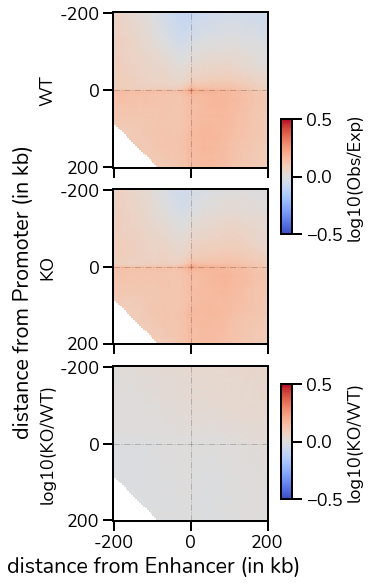

In [41]:
%%time

fig,ax = plt.subplots(3,1,figsize=(4,8),sharex=True,sharey=True,constrained_layout=True)
distRange = "30-300kb"

pileupKwargsDictOE = dict(cmap="coolwarm",vmin=-0.50,vmax=0.50,aspect="auto")
pileupKwargsDictRatio = dict(cmap="coolwarm",vmin=-0.5,vmax=0.5,aspect="auto")

centerAt = loopsFlankbig // microCRes
ax[0].set_xticks([0,centerAt,centerAt*2],[-loopsFlankbig//1000,0,loopsFlankbig//1000])
ax[0].set_yticks([0,centerAt,centerAt*2],[-loopsFlankbig//1000,0,loopsFlankbig//1000])
ax[0].set_ylabel("WT")
ax[1].set_ylabel("KO")
ax[2].set_ylabel("log10(KO/WT)")
    
# ax[0].set_title(condStr[ic])
pileupKwargsDict = pileupKwargsDictOE
df = pairSites2[distRange]#.query(i,engine="python")
print(i, len(df))
mask = maskCond1(df)

covWT = pairsPileup2[distRange]["WT"][:,:,list(df.index)].copy()
covWT[:, :, mask] = np.transpose(covWT[:, :, mask],axes=(1,0,2))[::-1, ::-1, ]#covWT[::-1, ::-1, mask]
ax[0].imshow(np.log10(np.nanmean(covWT,axis=2)),**pileupKwargsDict)
ax[0].set_aspect(1)
ax[0].axvline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
ax[0].axhline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
# ax[0].spines.bottom.set_visible(False)
# ax[0].spines.left.set_visible(False)

covKO = pairsPileup2[distRange]["KO"][:,:,list(df.index)].copy()
covKO[:, :, mask] = np.transpose(covKO[:, :, mask],axes=(1,0,2))[::-1, ::-1, ]#covKO[::-1, ::-1, mask]
ax[1].imshow(np.log10(np.nanmean(covKO,axis=2)),**pileupKwargsDict)
ax[1].set_aspect(1)
ax[1].axvline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
ax[1].axhline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
# ax[1].spines.bottom.set_visible(False)
# ax[1].spines.left.set_visible(False)

pileupKwargsDict = pileupKwargsDictRatio
ratio = np.log10(np.nanmean(covKO,axis=2)/np.nanmean(covWT,axis=2))
ax[2].imshow(ratio,**pileupKwargsDict)
ax[2].axvline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
ax[2].axhline(centerAt, lw=1, alpha=0.2, ls="-.", c="k")
ax[2].set_aspect(1)
# ax[2].spines.bottom.set_visible(False)
# ax[2].spines.left.set_visible(False)

ax2 = fig.add_axes([0.94, 0.6,0.04, 0.2])
cb2 = mpl.colorbar.ColorbarBase(ax2, orientation='vertical', 
                               cmap='coolwarm',norm=mpl.colors.Normalize(-0.50, 0.50),label="log10(Obs/Exp)")

ax3 = fig.add_axes([0.94, 0.14,0.04, 0.2])
cb3 = mpl.colorbar.ColorbarBase(ax3, orientation='vertical', 
                               cmap='coolwarm',norm=mpl.colors.Normalize(-0.50, 0.50),label="log10(KO/WT)")

# fig.suptitle(distRange)
fig.supylabel("distance from Promoter (in kb)")
fig.supxlabel("distance from Enhancer (in kb)")

# plt.savefig("microC_pileup_at_e-p_loops.png",dpi=300,bbox_inches="tight")
# plt.savefig("microC_pileup_at_e-p_loops.pdf",dpi=300,bbox_inches="tight")